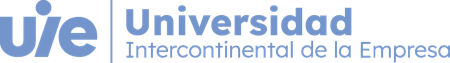

**G25GXX3.10X. Aprendizaje Automático**

**Profesor: Borja González Seoane**

Curso 2025-26

# PLD6. Clusterización con DBSCAN

En esta práctica se implementará y probará una versión _from scratch_ del algoritmo de clusterización DBSCAN. Se usarán datos generados sintéticamente para comprobar el funcionamiento del algoritmo, aprovechando para probar previamente el uso de *KMeans* sobre esos mismos datos, a modo de comparación. **Este _notebook_ servirá también para desglosar el algoritmo DBSCAN, visto en las transparencias de clase, utilizando celdas Markdown y comentarios para ir componiendo un guión y un pseudocódigo paso a paso.**


## Clusterización con DBSCAN

DBSCAN es un método que agrupa puntos que están muy cerca unos de otros y deja fuera los que están aislados. Podemos verlo como que son personas en una plaza,si hay varias juntas, forman un grupo,pero si alguien está solo, no pertenece a ninguno de estos grupos. Así, el algoritmo encuentra grupos de cualquier forma y también detecta los puntos que no encajan en ninguno.



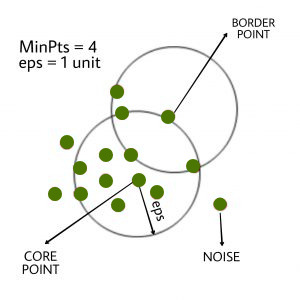

In [184]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN

# Importaciones...

## Creación de círculos concéntricos con puntos de ruido

Impleméntese una función auxiliar que genere una circunferencia de puntos de ruido. Parametrícese con `n` y `r` para el número de puntos y el radio de la circunferencia, respectivamente. Se usará esta función para la generación de datos sintéticos con los que confrontar *K-means* y DBSCAN.

In [185]:
# import sklearn.datasets 
# sklearn.datasets.make_circles

In [186]:
def puntos_en_circunferencias(n: int, r: int) -> np.ndarray:
    """
    Genera `n` puntos en una circunferencia de radio `r` con ruido gaussiano.
    """

    theta = np.linspace(0, 2*np.pi, n, endpoint=False)
    X = r * np.cos(theta) + np.random.normal(0, 0.1, n)
    Y = r * np.sin(theta) + np.random.normal(0, 0.1, n)
    return np.column_stack((X, Y))

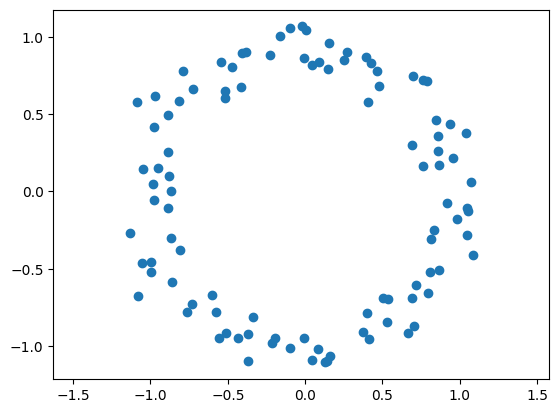

In [187]:
# Ejemplo con 100 puntos en una circunferencia de radio 1
circ_eg= puntos_en_circunferencias(100, 1)
plt.scatter(circ_eg[:,0], circ_eg[:,1])
plt.axis('equal')
plt.show()

In [188]:
# Crea 3 circunferencias concéntricas
circ1= puntos_en_circunferencias(100, 1)
circ2= puntos_en_circunferencias(200, 2)
circ3= puntos_en_circunferencias(300, 3)

# Concatena los puntos en la misma figura
circc= np.vstack([circ1, circ2, circ3])

# Añadimos algo de ruido para representar los valores atípicos
ruido= np.random.uniform(-4, 4, (15, 2))
circc= np.vstack((circc, ruido))

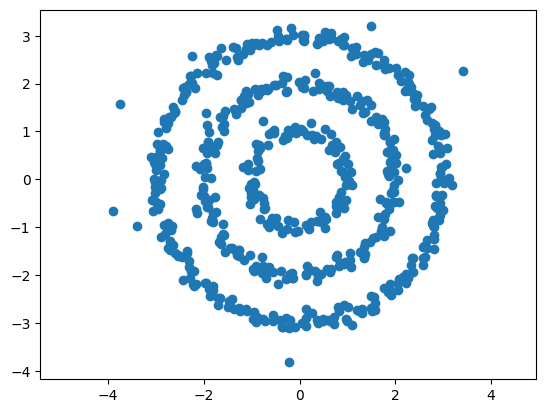

In [189]:
# Plot
plt.scatter(circc[:,0], circc[:,1])
plt.axis('equal')
plt.show()

In [190]:
X= circc

## Úsese *K-means* _scratch_ o Scikit-Learn para intentar clusterizar los datos generados

¿Qué ocurre? ¿Resulta útil *K-means* para este tipo de datos?

In [191]:
kmeans_sk=KMeans(n_clusters=3)
kmeans_sk.fit(circc)

,n_clusters,3
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


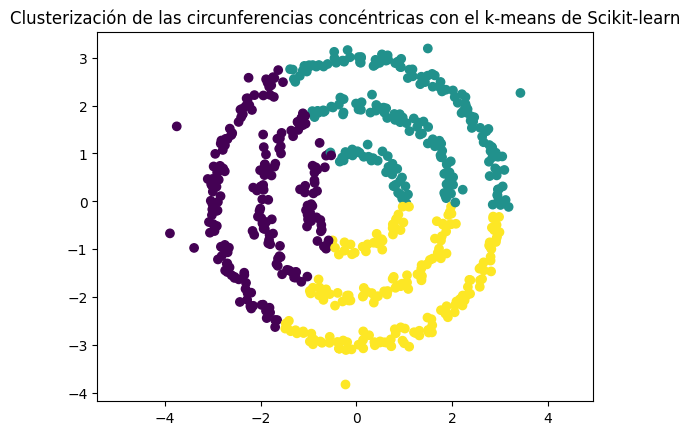

In [192]:
plt.scatter(
    X[:,0],
    X[:,1],
    c=kmeans_sk.labels_,
    cmap='viridis')
plt.title('Clusterización de las circunferencias concéntricas con el k-means de Scikit-learn')
plt.axis('equal')
plt.show()

## Prueba inicial con DBSCAN de Scikit-Learn

Para saber a qué atenerse a la hora de implementar DBSCAN _scratch_.

In [193]:
dbscan_sk=DBSCAN(eps=.5)
dbscan_sk.fit(X)

,eps,0.5
,min_samples,5
,metric,'euclidean'
,metric_params,None
,algorithm,'auto'
,leaf_size,30
,p,None
,n_jobs,None


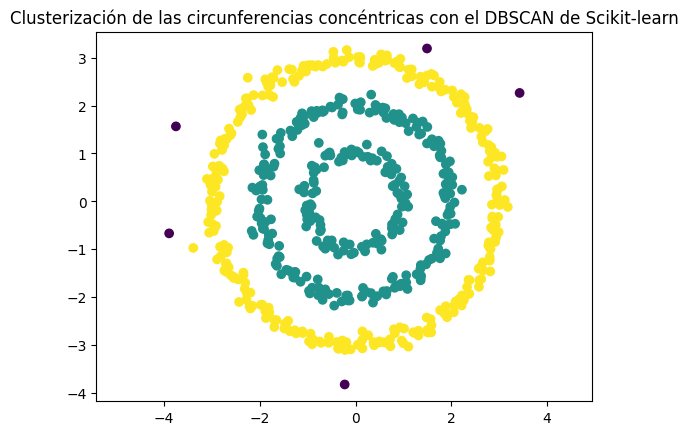

In [194]:
plt.scatter(
    X[:,0],
    X[:,1],
    c=dbscan_sk.labels_,
    cmap='viridis')
plt.title('Clusterización de las circunferencias concéntricas con el DBSCAN de Scikit-learn')
plt.axis('equal')
plt.show()

In [195]:
np.unique(dbscan_sk.labels_)

array([-1,  0,  1])

## DBSCAN _scratch_ paso a paso

Úsese la clase arquetipo habitual en las sesiones de laboratorio para implementar DBSCAN.

### Arquetipo

```python
class DBSCANScratch:
    def __init__(self):  # Constructor de la clase. Impleméntese si es necesario
        pass

    def fit(self, X: np.ndarray):
        raise NotImplementedError("Impleméntese este arquetipo esqueleto")

    def predict(self, X: np.ndarray) -> np.ndarray:
        raise NotImplementedError("Impleméntese este arquetipo esqueleto")
```

### Pseudocódigo
La clase `DBSCANScratch` es una implementación del algoritmo DBSCAN hecha desde cero. Su objetivo es encontrar grupos de puntos que estén muy cerca unos de otros y separar aquellos que están más aislados, considerándolos como ruido. Para hacerlo, el algoritmo mide las distancias entre los puntos: si un punto tiene varios vecinos dentro de una distancia determinada (`eps`), se convierte en un punto núcleo y comienza a formar un grupo junto con sus vecinos cercanos. Este proceso se repite hasta identificar todas las zonas densas de puntos, que se consideran clústeres. Al final, cada punto recibe una etiqueta que indica a qué grupo pertenece, y los que no encajan en ninguno se marcan como ruido.


In [196]:
from typing import Optional, Literal


class DBSCANScratch:
    def __init__(
        self,
        eps: float = 0.5,
        min_samples: int = 5,
        metric: Literal["euclidean", "manhattan"] = "euclidean",
    ):
       
        # Validación de parámetros
        if eps <= 0:
            raise ValueError("eps debe ser mayor que 0")
        if min_samples < 1:
            raise ValueError("min_samples debe ser al menos 1")
        
        self.eps = eps
        self.min_samples = min_samples
        self.metric = metric
        
        self._labels = None
        self._indices_nucleos = None
        self._n_clusters = 0
    
    
    def __calcular_distancia(self, punto1: np.ndarray, punto2: np.ndarray) -> float:
       
        if self.metric == "euclidean":
            return np.sqrt(np.sum((punto1 - punto2) ** 2))
        elif self.metric == "manhattan":
            return np.sum(np.abs(punto1 - punto2))
        else:
            raise ValueError(f"Métrica '{self.metric}' no soportada.")
    
    
    def __obtener_vecinos(self, X: np.ndarray, indice_punto: int) -> np.ndarray:
        vecinos = []
        punto = X[indice_punto]
        
        for idx in range(X.shape[0]):
            if self.__calcular_distancia(punto, X[idx]) <= self.eps:
                vecinos.append(idx)
        
        return np.array(vecinos)
    
    
    def __expandir_cluster(
        self,
        X: np.ndarray,
        indice_punto: int,
        vecinos: np.ndarray,
        id_cluster: int,
        etiquetas: np.ndarray,
        visitados: np.ndarray
    ) -> None:
      
        # Asignamos el punto inicial al cluster
        etiquetas[indice_punto] = id_cluster
        
        # Cola de puntos a procesar
        i = 0
        while i < len(vecinos):
            indice_vecino = vecinos[i]
            
            # Si no ha sido visitado, lo marcamos como visitado
            if not visitados[indice_vecino]:
                visitados[indice_vecino] = True
                
                # Buscamos los vecinos de este punto
                vecinos_del_vecino = self.__obtener_vecinos(X, indice_vecino)
                
                # Si es un punto núcleo, añadimos sus vecinos a la cola
                if len(vecinos_del_vecino) >= self.min_samples:
                    vecinos = np.concatenate([vecinos, vecinos_del_vecino])
            
            # Si el punto no tiene asignación o es ruido, lo asignamos al cluster
            if etiquetas[indice_vecino] == -1:
                etiquetas[indice_vecino] = id_cluster
            
            i += 1
    
    
    def fit(self, X: np.ndarray):
       
        n_muestras = X.shape[0]
        
        # Inicializamos las etiquetas como -1 (ruido)
        etiquetas = np.full(n_muestras, -1, dtype=int)
        
        # Array para marcar puntos visitados
        visitados = np.zeros(n_muestras, dtype=bool)
        
        # Lista para almacenar índices de puntos núcleo
        puntos_nucleos = []
        
        # ID del cluster actual
        id_cluster = 0
        
        # Iteramos sobre todos los puntos
        for indice_punto in range(n_muestras):
            # Si ya fue visitado, continuamos
            if visitados[indice_punto]:
                continue
            
            # Marcamos como visitado
            visitados[indice_punto] = True
            
            # Encontramos los vecinos del punto
            vecinos = self.__obtener_vecinos(X, indice_punto)
            
            # Si no tiene suficientes vecinos, lo marcamos como ruido
            if len(vecinos) < self.min_samples:
                etiquetas[indice_punto] = -1
            else:
                # Es un punto núcleo, expandimos el cluster
                puntos_nucleos.append(indice_punto)
                self.__expandir_cluster(X, indice_punto, vecinos, id_cluster, etiquetas, visitados)
                id_cluster += 1
        
        # Guardamos los resultados
        self._labels = etiquetas
        self._indices_nucleos = np.array(puntos_nucleos)
        self._n_clusters = id_cluster

## Prueba de la implementación de DBSCAN

In [197]:
dbscan_sk_scracth=DBSCANScratch(eps=0.3, min_samples=5, metric="euclidean")
dbscan_sk_scracth.fit(X)

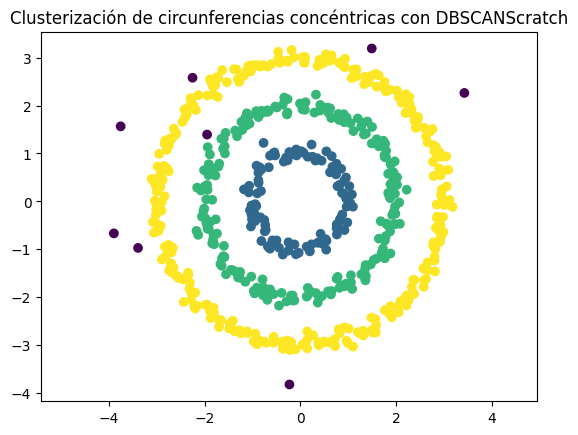

In [ ]:
# Mostramos los resultados de la clusterización
plt.scatter(
    X[:, 0],
    X[:, 1],
    c=dbscan_sk_scracth._labels,   
)
plt.title('Clusterización de circunferencias concéntricas con DBSCANScratch')
plt.axis('equal')
plt.show()